# Index
- [Imports](#Imports)
- [CTEPG](#CTEPG-(Catching-The-Elusive-Predictable-Genes)-15-06-2020---22-06-2020)
- [Dyslipid database creation](#Creating-dyslipid-dataset)
- [Match / unmatch new results to old results (benign/pathogenic)](#AUC-validation-vanilla-new-model)
- [New 2.0 models](#2.0-Base-models)
- [Cross validated models](#CV-Models)
- [XGB models out of CV models](#New-Models)
- [Correct new threshold](#Correct-probability-prediction)
- [AUC preparation & analysis](#Preparing-for-AUC-analysis)
- [AUC analysis dyslipid model](#AUC-analysis-of-dyslipid-model)
- [AUC analysis erfelijke kanker model](#AUC-analysis-on-EK-model)
- [Model on best performing panel, preparation](#Model-on-best-performing-panel,-prepartation)
- [AUC analysis new model on UMCG genepanels](#AUC-analysis-new-model-on-UMCG-genepanels)
- [Barplot of type of variants for each panel](#Barplot-of-type-of-variants-for-each-panel)

# Imports

In [1]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
import math
import json
import glob
import gzip
import pickle
import xgboost as xgb
from utilities import perform_stats, calc_z_scores
from utilities import get_header, genepanel_analysis, auc_analysis
from utilities import analyze_auc_per_gene, correct_threshold, read_capice_output
from sklearn.metrics import recall_score, roc_auc_score, precision_score, f1_score

# Defining some import and export locations
location = 'rjsietsma'
read_loc = '/run/media/rjsietsma/evo2tb/linux/Datafiles/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'
img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

with open('./umcg_genepanels.json', 'r') as panels:
    genepanels = json.load(panels)
    genepanels.pop('5GPM', None)

 # CTEPG (Catching The Elusive Predictable Genes) 15-06-2020 - 22-06-2020
 [Index](#Index)
<br/><br/>

What have I done:

- Made plot of Panel vs all combined:
![Panel vs all combined](img/allvs1boxplot_umcggenepanels.png)

- Issued [pull request](https://github.com/molgenis/capice/pull/1) for Dennis and Bart to be able to work with CAPICE locally.
- Refactored CAPICE code _(not finished)_.
- Retrained new models.
- Found new Pathogenic / Benign threshold within CAPICE.
- Made fancy new notebook with [indexing](#Index).



Planned for this week:
- Make barplot of type of variants for each panel.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Rebuild benchmarking dataset to the full dataset in Initial Data Exploration.
- Model refinement:
    - AUC analysis of new model (model xgb_booster37.pickle.dat)
    - Check for improvements.
    - Then split the training / testing data in the different models. (xgb_booster37.pickle.dat and xgb_booster_dyslipid.pickle.dat)
        - Also do the full dataset on dyslipid. Do not try to split the data into the 2 models. 
        - Try to build new models on average performing and well performing panels aswell, try to see if everything improves nicely.
            - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
        - _Note: Shuang her data has almost half the variants than the newer VGKL and Clinvar datasets, with 3913 benign and 1116 malignant samples._
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Dyslipid and Erfelijke kanker
- AUC analysis of dyslipid panel
    - Interestingly: it performs only SLIGHTLY better than the 2.0 base model:
<br/><br/>

AUC 2.0 base:

- Test: 0.7743036340158642
- Train: 0.9822742260567594

AUC 2.0 Dyslipid:

- Test: 0.7770706511713705
- Train: 0.9827123551221991
<br/><br/>

    - Note: AUC analysis is performed with an updated threshold, see the correct_threshold function.
    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- ~Make barplot of type of variants for each panel.~
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Base 2.0, Dyslipid
    - End AUC base: validation_0-auc:0.97662
    - End AUC dyslipid: validation_0-auc:0.98676
- [Make barplot of type of variants for each panel.]()

    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# Creating dyslipid dataset
[Index](#Index)

In [2]:
file_loc = os.path.join(read_loc, 'train.txt.gz')
header = get_header(file_loc, '#Chrom')
train = pd.read_csv(file_loc, compression='gzip', names=header, comment='#', sep='\t', low_memory=False)
train

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


In [3]:
with open('./umcg_genepanels.json', 'r') as json_file:
    genes = json.load(json_file)
dislipid_genes = genes['Hart- en vaatziekten']
genelist = []
for key, value in dislipid_genes.items():
    if key.lower().startswith('dyslipid'):
        for g in value:
            if g not in genelist:
                genelist.append(g)

In [4]:
dislipid_subset = train.loc[train['GeneName'].isin(genelist)]
dislipid_subset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
142,16,False,T,CodingTranscript,False,False,CCDS10772.1,848.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.928,2.614,False,1.0
148,19,False,CCGGCGAGGTGCAGGCCATGCT,CodingTranscript,False,False,CCDS12647.1,409.0,True,protein_altering,...,NaN,NaN,vkgl,NaN,NaN,True,0.863,0.839,False,1.0
149,2,False,C,CodingTranscript,False,False,CCDS1703.1,13028.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,0.058,False,1.0
150,2,False,G,CodingTranscript,False,False,CCDS1703.1,28.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.021,-0.103,False,1.0
151,2,False,C,CodingTranscript,False,False,CCDS1703.1,2534.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.653,0.251,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334284,12,False,T,CodingTranscript,False,False,CCDS8685.1,1093.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.999,3.072,False,0.8
334285,12,False,A,CodingTranscript,False,False,CCDS8685.1,1475.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.580,0.563,False,0.8
334286,12,False,T,CodingTranscript,False,False,CCDS8685.1,1537.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.643,False,0.8
334287,12,False,G,CodingTranscript,False,False,CCDS8685.1,1553.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.510,2.765,False,0.8


In [5]:
dislipid_subset['label'].value_counts()

Benign        3913
Pathogenic    1116
Name: label, dtype: int64

# 2.0 Base models
[Index](#Index)

In [6]:
model = pickle.load(open('./test_output/model_2_0/base/xgb_ransearch.pickle.dat', 'rb'))
print(f"The best score of Base model 2.0 is: {model.best_score} at iteration {model.best_iteration}")

The best score of Base model 2.0 is: 0.976629 at iteration 417


### Threshold analysis

In [35]:
train_base20 = read_capice_output('./test_output/model_2_0/result_files/train_base2_0.txt')
train_base20

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,FRAME_SHIFT,26.600,9.999967e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA
1,LDLR,FRAME_SHIFT,35.000,9.999961e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
2,LDLR,FRAME_SHIFT,34.000,9.999925e-01,Pathogenic,Pathogenic,19,11216255,AAATCTGACG,TGCAA
3,LDLR,FRAME_SHIFT,34.000,9.999908e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA1,FRAME_SHIFT,27.300,9.999901e-01,Pathogenic,Pathogenic,17,41246611,AG,A
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,6.942,3.544337e-07,Neutral,Neutral,17,10404694,G,A
334597,LIG4,3PRIME_UTR,1.122,3.442061e-07,Neutral,Neutral,13,108860318,C,CATT
334598,MIR548AZ,NON_SYNONYMOUS,12.180,3.056727e-07,Neutral,Neutral,14,64519911,G,A
334599,MIR548AZ,SYNONYMOUS,15.650,2.615435e-07,Neutral,Neutral,14,64692103,G,A


In [34]:
# correct_threshold(train_base20)

The real recall of input is: 0.9401193334442675,
at a threshold of: 0.149.
Precision score: 0.9401193334442675
F1 score: 0.955866002803693


(0.9401193334442675, 0.149)

In [37]:
test_base20 = read_capice_output('./test_output/model_2_0/result_files/test_base2_0.txt')
print("XGBoost 1.1.1, python3.8, threshold 0.02:")
auc_analysis(train_base20, test_base20)

AUC analysis of the training dataset reveals AUC: 0.9672333074855137
AUC analysis of the testing dataset reveals AUC: 0.6923076923076923


In [32]:
train_base20ct = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_correctthres.txt')
test_base20ct = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_correctthres.txt')
print("XGboost 1.1.1, python3.8, using threshold 0.149:")
auc_analysis(train_base20ct, test_base20ct)

XGboost 1.1.1, python3.8, using threshold 0.149:
AUC analysis of the training dataset reveals AUC: 0.9817894006301696
AUC analysis of the testing dataset reveals AUC: 0.774764803541782


Why is base 2.0 model not showing a threshold close to 0.02?
#### Investigating original threshold

In [19]:
train_base = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721.txt')
train_base

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA
1,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
2,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT
3,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic,2,47702328,GTTGA,TTTC
...,...,...,...,...,...,...,...,...,...,...
334596,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral,14,64653189,T,C
334597,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral,17,10419945,A,G
334598,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral,17,10419849,T,G
334599,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral,16,88804658,G,A


In [20]:
# train_base_recall, train_base_threshold = correct_threshold(train_base)

The real recall of input is: 0.9402215250047538,
at a threshold of: 0.152.
Precision score: 0.9402215250047538
F1 score: 0.956025763416432


In [21]:
train_in = pd.read_csv(
     '~/PycharmProjects/dsls_master_thesis/'
     'side_scripts/datafiles/train.txt.gz',
      compression='gzip', sep='\t', low_memory=False)
data = train_base.merge(
     train_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']],
     left_on=['chr', 'pos', 'ref', 'alt'],
     right_on=['#Chrom', 'Pos', 'Ref', 'Alt'])
drop_labels = ['#Chrom', 'Pos', 'Ref', 'Alt']
for x in data.columns:
    if x.endswith('_x') or x.endswith('_y'):
        drop_labels.append(x)
data.drop(columns=drop_labels, inplace=True)
data

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA,Pathogenic
1,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,Pathogenic
2,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,Pathogenic
3,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA,Pathogenic
4,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic,2,47702328,GTTGA,TTTC,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...
334596,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral,14,64653189,T,C,Benign
334597,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral,17,10419945,A,G,Benign
334598,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral,17,10419849,T,G,Benign
334599,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral,16,88804658,G,A,Benign


In [22]:
def default_threshold(row):
    return_value = 0
    if row > 0.02:
        return_value = 1
    return return_value

In [23]:
data['pred'] = data['probabilities'].apply(lambda x: default_threshold(x))

In [24]:
data['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [25]:
y_true = np.array(data['label'])
y_pred = np.array(data['pred'])
print(f"The recall score of using Python3.8 and threshold 0.02 is: {recall_score(y_true, y_pred)}")
print(f"The precision score of using Python3.8 and threshold 0.02 is: {precision_score(y_true, y_pred)}")
print(f"Resulting in a F1 score of: {f1_score(y_true, y_pred)}")

The recall score of using Python3.8 and threshold 0.02 is: 0.9893316290160026
The precision score of using Python3.8 and threshold 0.02 is: 0.7102746011577016
Resulting in a F1 score of: 0.8268940366736864


In [26]:
test_base = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721.txt')
test_base

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,MSH2,FRAME_SHIFT,34.000,0.999988,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
1,BRCA1,FRAME_SHIFT,22.000,0.999986,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT
2,BRCA1,STOP_GAINED,34.000,0.999983,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
3,BRCA2,FRAME_SHIFT,17.090,0.999981,Pathogenic,Pathogenic,13,32906819,GG,G
4,BRCA2,FRAME_SHIFT,22.300,0.999981,Pathogenic,Pathogenic,13,32913009,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.220,0.000002,Neutral,Neutral,14,64593063,G,A
10838,LOC100289580,UPSTREAM,1.856,0.000002,Neutral,Neutral,16,88798720,G,A
10839,MYHAS,DOWNSTREAM,0.035,0.000002,Neutral,Neutral,17,10442488,G,A
10840,MIR548AZ,NON_SYNONYMOUS,1.347,0.000001,Neutral,Neutral,14,64519932,A,G


In [27]:
print('Using XGboost 0.72.1 on python3.8, default threshold (0.02):')
auc_analysis(train_base, test_base)

Using XGboost 0.72.1 on python3.8, default threshold (0.02):
AUC analysis of the training dataset reveals AUC: 0.9667381471155135
AUC analysis of the testing dataset reveals AUC: 0.6892639734366353


##### AUC analysis, but now with a new threshold.


In [29]:
train_basect = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721_correctthres.txt')
test_basect = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721_correctthres.txt')
print("Using XGboost 0.72.1 on python3.8, threshold set to 0.152:")
auc_analysis(train_basect, test_basect)

Using XGboost 0.72.1 on python3.8, threshold set to 0.152:
AUC analysis of the training dataset reveals AUC: 0.9819068219526765
AUC analysis of the testing dataset reveals AUC: 0.7744881018262314


So in the end:
- Base 0.72.1 model:
    - Unaltered threshold:
        - Train: 0.9667381471155135
        - Test: 0.6892639734366353
    - Updated threshold (0.152):
        - Train: 0.9819068219526765
        - Test: 0.7744881018262314
- Updated 1.1.1 model:
    - Unaltered threshold:
        - Train: 0.9672333074855137
        - Test: 0.6923076923076923
    - Updated threshold (0.149):
        - Train: 0.9817894006301696
        - Test: 0.774764803541782

Performance is VERY similar.

# CV Models
[Index](#Index)

In [17]:
model = pickle.load(open('./models/xgb_weightedSample_randomsearch_v2.pickle.dat', 'rb'))
xgbmodel = model.best_estimator_
xgbmodel.get_booster().feature_names

['CDSpos',
 'CpG',
 'Dist2Mutation',
 'Dst2Splice',
 'EncExp',
 'EncH3K27Ac',
 'EncH3K4Me1',
 'EncH3K4Me3',
 'EncNucleo',
 'EncOCC',
 'EncOCCombPVal',
 'EncOCDNasePVal',
 'EncOCDNaseSig',
 'EncOCFairePVal',
 'EncOCFaireSig',
 'EncOCctcfPVal',
 'EncOCctcfSig',
 'EncOCmycPVal',
 'EncOCmycSig',
 'EncOCpolIIPVal',
 'EncOCpolIISig',
 'Freq10000bp',
 'Freq1000bp',
 'Freq100bp',
 'GC',
 'GerpN',
 'GerpRS',
 'GerpRSpval',
 'GerpS',
 'Grantham',
 'Length',
 'PolyPhenVal',
 'Rare10000bp',
 'Rare1000bp',
 'Rare100bp',
 'SIFTval',
 'Sngl10000bp',
 'Sngl1000bp',
 'Sngl100bp',
 'TFBS',
 'TFBSPeaks',
 'TFBSPeaksMax',
 'bStatistic',
 'cDNApos',
 'cHmmBivFlnk',
 'cHmmEnh',
 'cHmmEnhBiv',
 'cHmmEnhG',
 'cHmmHet',
 'cHmmQuies',
 'cHmmReprPC',
 'cHmmReprPCWk',
 'cHmmTssA',
 'cHmmTssAFlnk',
 'cHmmTssBiv',
 'cHmmTx',
 'cHmmTxFlnk',
 'cHmmTxWk',
 'cHmmZnfRpts',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'mamPhCons',
 'mamPhyloP',
 'minDistTSE',
 'minDistTSS',
 'mirSVR-Aln',
 'mirSVR-E',
 'mirSVR-Score',
 'm

In [18]:
model_dislipid = pickle.load(open('./models/xgb_weightedSample_randomsearch_dislipid.pickle.dat', 'rb'))
xgbmodel_dislipid = model_dislipid.best_estimator_
xgbmodel_dislipid.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1968770013672272,
 'max_delta_step': 0,
 'max_depth': 16,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 427,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 1}

In [19]:
model_ek = pickle.load(open('./models/xgb_ransearch_ek_dataset.pickle.dat', 'rb'))

# New Models
[Index](#Index)

In [20]:
model = pickle.load(open('./xgbmodels/xgb_booster_v2.pickle.dat', 'rb'))
model.feature_importances_

array([0.00282909, 0.00207738, 0.00183909, 0.00320904, 0.00281486,
       0.00190347, 0.00192447, 0.00191927, 0.00175739, 0.00351866,
       0.00253019, 0.00301028, 0.00308079, 0.00301589, 0.00242207,
       0.00284953, 0.00254809, 0.00301885, 0.00276217, 0.00329895,
       0.0029472 , 0.00288387, 0.00196225, 0.00324255, 0.00249287,
       0.00308638, 0.00275804, 0.00326703, 0.003321  , 0.02822421,
       0.01098935, 0.00849544, 0.0026135 , 0.0021958 , 0.00212344,
       0.02957111, 0.00307086, 0.00227875, 0.00224516, 0.00332749,
       0.00291972, 0.00251198, 0.00405553, 0.00422445, 0.00319547,
       0.00250752, 0.00358728, 0.0023705 , 0.00314594, 0.00369558,
       0.00300821, 0.00350186, 0.00383268, 0.00286349, 0.00239821,
       0.00318689, 0.00370395, 0.00359068, 0.00305595, 0.01804393,
       0.00381216, 0.00197791, 0.0018304 , 0.0023901 , 0.00244684,
       0.00294106, 0.00317492, 0.00303257, 0.00199907, 0.00196537,
       0.00232091, 0.00312337, 0.00172605, 0.00178056, 0.     

In [21]:
model_dislipid = pickle.load(open('./xgbmodels/xgb_booster_dyslipid.pickle.dat', 'rb'))
model_dislipid.feature_importances_

array([0.00278866, 0.00208772, 0.00174322, 0.00296931, 0.00269667,
       0.00179555, 0.00186813, 0.00186437, 0.00175499, 0.00395201,
       0.00240749, 0.00280701, 0.00290935, 0.00285559, 0.0023123 ,
       0.0027687 , 0.0024073 , 0.00306501, 0.00286279, 0.00350749,
       0.00261141, 0.00282689, 0.00188535, 0.00320358, 0.00238541,
       0.00293148, 0.00261692, 0.00331071, 0.00368271, 0.02656523,
       0.01037843, 0.00846208, 0.00255091, 0.00212624, 0.00206606,
       0.03021989, 0.0027948 , 0.00225078, 0.00219586, 0.00343691,
       0.00298393, 0.00254942, 0.00387159, 0.00394147, 0.00327632,
       0.00257063, 0.00359947, 0.00250112, 0.00339626, 0.00355939,
       0.0030033 , 0.00344496, 0.00338445, 0.00294264, 0.00213853,
       0.00313247, 0.00377457, 0.00349594, 0.00298174, 0.01875002,
       0.00379864, 0.00185824, 0.00179364, 0.00239529, 0.00231335,
       0.00317147, 0.00292523, 0.00316273, 0.00262851, 0.00228997,
       0.00601442, 0.00521736, 0.00169761, 0.00183883, 0.     

In [22]:
model_ek = model_ek.best_estimator_
model_ek.feature_importances_

array([5.0133662e-03, 1.2882849e-03, 1.0817926e-03, 6.3643702e-03,
       2.4500915e-03, 1.2766811e-03, 1.6910619e-03, 1.9211929e-03,
       1.3221180e-03, 1.4542753e-03, 1.7586007e-03, 3.7318198e-03,
       1.4746373e-03, 2.0313114e-03, 1.3998400e-03, 1.0245102e-03,
       1.8737183e-03, 1.2974218e-03, 1.8016534e-03, 1.4174232e-03,
       1.7281594e-03, 2.0112914e-03, 1.3021030e-03, 1.5508684e-03,
       2.8008316e-03, 1.2582513e-03, 1.9976879e-03, 2.1160368e-03,
       2.7596293e-02, 4.1479445e-03, 1.9538682e-02, 1.1834032e-02,
       1.5302061e-03, 1.3707022e-03, 1.8456797e-03, 2.6172997e-02,
       2.8442349e-03, 1.3298710e-03, 1.2373156e-03, 1.3766757e-03,
       1.9199389e-03, 1.9936443e-03, 4.2407308e-03, 2.6613504e-03,
       4.2698625e-03, 1.5507338e-03, 2.0464479e-03, 1.2644089e-03,
       1.8295237e-03, 2.7150142e-03, 2.2141868e-03, 4.2772172e-03,
       4.4871587e-03, 1.0170736e-03, 1.9717950e-03, 1.3658322e-03,
       1.7440096e-03, 1.4196830e-03, 1.5646445e-03, 1.7786717e

# AUC validation vanilla new model
[Index](#Index)

In [23]:
train_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/train_results.txt', sep='\t', low_memory=False)
train_original

,chr,pos,ref,alt,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction
0,17,41246652,ACATTC,GA,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic
1,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic
2,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic
3,19,11216262,ACG,CA,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic
4,2,47702328,GTTGA,TTTC,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic
...,...,...,...,...,...,...,...,...,...,...
334596,14,64653189,T,C,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral
334597,17,10419945,A,G,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral
334598,17,10419849,T,G,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral
334599,16,88804658,G,A,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral


In [24]:
train_new = read_capice_output('./datafiles/train_results_v4.txt.gz')
train_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A


In [25]:
merge = train_original[['chr', 'pos','ref','alt','prediction']].merge(train_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / train_original.shape[0] * 100}% mismatch.")

There is a 4.3523480204781215% mismatch.


In [26]:
test_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/test_results.txt', sep='\t', low_memory=False)
tellPathogenic_pred = lambda x: "Pathogenic" if x > 0.02 else 'Neutral'
test_original['prediction'] = [tellPathogenic_pred(probability) for probability in test_original['capice']]
test_original.rename(columns={'#Chrom': 'chr', 'Pos':'pos', 'Ref': 'ref', 'Alt':'alt'}, inplace=True)
test_original

,chr,pos,ref,alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,prediction
0,21,33974174,C,G,0.000058,STOP_LOST,LB/B,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,Neutral
1,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,0.806,NaN,0.000075,NaN,Neutral
2,17,29509638,C,T,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.647,-0.0,10.760,NaN,0.001511,NaN,Neutral
3,21,35742999,C,T,0.000133,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,18.640,NaN,0.000621,NaN,Neutral
4,1,2160973,G,A,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,16.340,0.008252,0.000012,NaN,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10837,17,29556342,G,A,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,11.450,NaN,0.000139,NaN,Neutral
10838,11,5248177,A,T,0.000344,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,17.970,NaN,0.069934,NaN,Pathogenic
10839,15,48787324,T,C,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.664,-0.0,12.170,0.019530,0.909190,NaN,Pathogenic
10840,19,17947957,G,A,0.000015,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,10.990,NaN,0.001238,NaN,Neutral


In [27]:
test_new = read_capice_output('./datafiles/test_results_v4.txt.gz')
test_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A


In [28]:
merge = test_original[['chr', 'pos','ref','alt','prediction']].merge(test_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / test_original.shape[0] * 100}% mismatch.")

There is a 14.25936174137613% mismatch.


# Correct probability prediction
[Index](#Index)

In [29]:
# dyslipid_train_res = pd.read_csv('/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/test_output/train_results_dyslipid.txt',
#                   sep='\t', low_memory=False)
# dyslipid_true_recall, dyslipid_true_threshold = correct_threshold(dyslipid_train_res)
# print(f"Recall of dyslipid model has been reached: {dyslipid_true_recall}, for threshold: {dyslipid_true_threshold}")

# Preparing for AUC analysis
[Index](#Index)


In [30]:
train_out = train_new.copy()
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A


In [31]:
train_in = pd.read_csv('./datafiles/train.txt.gz',
                      compression='gzip', sep='\t', low_memory=False)
train_in

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


In [32]:
train_out = train_out.merge(train_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']],
                           left_on=['chr','pos','ref','alt'],
                           right_on=['#Chrom','Pos','Ref','Alt'])
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,#Chrom,Pos,Ref,Alt,label
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT,19,11216252,GACAAA,TTT,Pathogenic
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG,13,32936775,GAATTT,AG,Pathogenic
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,Pathogenic
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA,19,11216262,ACG,CA,Pathogenic
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT,13,32906847,TACCCCTATTG,ACAT,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A,17,10429043,G,A,Benign
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G,17,10415744,A,G,Benign
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A,4,39448569,G,A,Benign
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A,17,10318882,G,A,Benign


In [33]:
drop_labels = ['#Chrom', 'Pos', 'Ref', 'Alt']
for x in train_out.columns:
    if x.endswith('_x') or x.endswith('_y'):
        drop_labels.append(x)
drop_labels

['#Chrom', 'Pos', 'Ref', 'Alt']

In [34]:
train_out.drop(columns=drop_labels, inplace=True)

In [35]:
train_out['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
train_out['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,1,Pathogenic,19,11216252,GACAAA,TTT,1
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,1,Pathogenic,13,32936775,GAATTT,AG,1
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,1,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,1
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,1,Pathogenic,19,11216262,ACG,CA,1
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,1,Pathogenic,13,32906847,TACCCCTATTG,ACAT,1
...,...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,0,Neutral,17,10429043,G,A,0
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,0,Neutral,17,10415744,A,G,0
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,0,Neutral,4,39448569,G,A,0
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,0,Neutral,17,10318882,G,A,0


In [36]:
y_true = np.array(train_out['label'])
y_pred = np.array(train_out['prediction'])
print(f"AUC value of 2.0 model on train dataset: {roc_auc_score(y_true, y_pred)}")

AUC value of 2.0 model on train dataset: 0.9822742260567594


In [37]:
test = test_new.copy()

In [38]:
test

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A


In [39]:
test_in = pd.read_csv('./datafiles/test.txt.gz',
                            compression='gzip',
                            low_memory=False,
                           sep='\t')
test_in = test_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']]
test_in.columns = ['chr', 'pos', 'ref', 'alt', 'label']
test_in

,chr,pos,ref,alt,label
0,21,33974174,C,G,Benign
1,X,99661625,G,C,Benign
2,17,29509638,C,T,Benign
3,21,35742999,C,T,Benign
4,1,2160973,G,A,Benign
...,...,...,...,...,...
10837,17,29556342,G,A,Pathogenic
10838,11,5248177,A,T,Pathogenic
10839,15,48787324,T,C,Pathogenic
10840,19,17947957,G,A,Pathogenic


In [40]:
test = test.merge(test_in)
test

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT,Pathogenic
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT,Pathogenic
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT,Pathogenic
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T,Pathogenic
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C,Benign
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A,Benign
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G,Benign
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A,Benign


In [41]:
test['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
test['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [42]:
y_true = np.array(test['label'])
y_pred = np.array(test['prediction'])
print(f"AUC value of 2.0 model on test dataset: {roc_auc_score(y_true, y_pred)}")

AUC value of 2.0 model on test dataset: 0.7743036340158642


In [43]:
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,1,Pathogenic,19,11216252,GACAAA,TTT,1
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,1,Pathogenic,13,32936775,GAATTT,AG,1
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,1,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,1
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,1,Pathogenic,19,11216262,ACG,CA,1
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,1,Pathogenic,13,32906847,TACCCCTATTG,ACAT,1
...,...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,0,Neutral,17,10429043,G,A,0
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,0,Neutral,17,10415744,A,G,0
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,0,Neutral,4,39448569,G,A,0
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,0,Neutral,17,10318882,G,A,0


In [44]:
train_out['source'] = 'train'
test['source'] = 'test'
full = train_out.append(test, ignore_index=True)
full

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label,source
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,1,Pathogenic,19,11216252,GACAAA,TTT,1,train
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,1,Pathogenic,13,32936775,GAATTT,AG,1,train
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,1,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,1,train
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,1,Pathogenic,19,11216262,ACG,CA,1,train
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,1,Pathogenic,13,32906847,TACCCCTATTG,ACAT,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...
345438,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,0,Neutral,14,64537567,G,C,0,test
345439,MYHAS,INTRONIC,0.068,8.699849e-07,0,Neutral,17,10432854,G,A,0,test
345440,NBPF20,REGULATORY,3.320,6.732982e-07,0,Neutral,1,145439717,C,G,0,test
345441,MYHAS,DOWNSTREAM,0.035,6.130708e-07,0,Neutral,17,10442488,G,A,0,test


In [45]:
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_37.csv')

In [46]:
# The 10 worst performing genes in the new model. SPTLC2 is again amongst them.

auc_analysis.sort_values(by='auc').head(10)

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2218,2218,MFAP5,0.437500,0.0,0.0,1.0,0.0,40,1,41,38,3
2221,2221,GFM2,0.447368,0.0,0.0,1.0,0.0,114,2,116,107,9
2257,2257,SLC10A2,0.471429,0.0,0.0,1.0,0.0,35,1,36,30,6
2270,2270,C2,0.472222,0.0,0.0,1.0,0.0,18,1,19,18,1
2280,2280,AFF4,0.475000,0.0,0.0,1.0,0.0,20,1,21,21,0
2261,2261,TSHZ1,0.477612,0.0,0.0,1.0,0.0,67,1,68,66,2
2278,2278,KCNK9,0.487179,0.0,0.0,1.0,0.0,39,1,40,39,1
2248,2248,SPTLC2,0.490385,0.0,0.0,1.0,0.0,208,2,210,208,2
2223,2223,ATP6AP1,0.492188,0.0,0.0,1.0,0.0,64,1,65,63,2
2282,2282,GJB3,0.494318,0.0,0.0,1.0,0.0,88,2,90,90,0


In [47]:
# Average auc is pretty good though.

print(f"Mean of new model: {auc_analysis['auc'].mean()} \nMedian of new model: {auc_analysis['auc'].median()}")

Mean of new model: 0.9512713923971363 
Median of new model: 0.9893045069778084


In [48]:
previous_model_auc = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/auc_results.csv', index_col=0)
previous_model_auc = previous_model_auc[['Gene', 'AUC']]
previous_model_auc.columns = ['gene', 'auc_previous']

In [49]:
# On average, the new model does perform better

print(f"Mean of previous model: {previous_model_auc['auc_previous'].mean()} \nMedian of previous model: {previous_model_auc['auc_previous'].median()}")

Mean of previous model: 0.9448573343008154 
Median of previous model: 0.96875


In [50]:
old_new = auc_analysis.merge(previous_model_auc, how='left')
old_new

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous
0,0,LDLR,0.983725,0.992126,0.991259,0.008741,0.992995,336,1144,1480,1325,155,0.905925
1,1,BRCA2,0.992003,0.995261,0.997110,0.002890,0.993418,1221,2422,3643,2973,670,0.946305
2,2,BRCA1,0.986892,0.992528,0.993808,0.006192,0.991251,849,1938,2787,2226,561,0.949156
3,3,MSH2,0.989096,0.990902,0.988449,0.011551,0.993367,390,606,996,850,146,0.955128
4,4,USH2A,0.977106,0.970238,0.970238,0.029762,0.970238,312,168,480,459,21,0.944790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2349,NLRP1,0.500000,0.000000,0.000000,1.000000,0.000000,14,1,15,15,0,NaN
2350,2350,APOA1,1.000000,1.000000,1.000000,0.000000,1.000000,9,1,10,9,1,NaN
2351,2351,IL2RG,0.500000,0.000000,0.000000,1.000000,0.000000,6,1,7,6,1,NaN
2352,2352,SGSM3,1.000000,1.000000,1.000000,0.000000,1.000000,3,1,4,3,1,NaN


In [51]:
unmerged = previous_model_auc.merge(auc_analysis, how='left').dropna(subset=['auc_previous'])
unmerged['auc'].isnull().any()

# No genes are missing from the previous dataset, so essentially only more genes got an AUC now.

False

In [52]:
old_new['delta'] = old_new['auc'] - old_new['auc_previous']

In [53]:
n_improved = old_new[old_new['delta'] > 0].shape[0]
n_i_p = n_improved / old_new.shape[0] * 100
n_worsen = old_new[old_new['delta'] < 0].shape[0]
n_w_p = n_worsen / old_new.shape[0] * 100
n_same = old_new[old_new['delta'] == 0].shape[0]
n_s_p = n_same / old_new.shape[0] * 100
n_no_data = old_new.shape[0] - (n_improved + n_worsen + n_same)
n_nd_p = n_no_data / old_new.shape[0] * 100
print(
    f"The amount of genes that improved: {n_improved}({round(n_i_p)}%),\n"
    f"The amount of genes worsen: {n_worsen}({round(n_w_p)}%),\n"
    f"and the amount of genes stayed the same: {n_same}({round(n_s_p)}%),\n"
    f"(no data: {n_no_data}({round(n_nd_p)}%))"
)

The amount of genes that improved: 1285(55%),
The amount of genes worsen: 398(17%),
and the amount of genes stayed the same: 609(26%),
(no data: 62(3%))


In [54]:
old_new_2 = old_new.where(
    (old_new['auc'] != 0.5) & 
    (old_new['auc'] != 1.0) & 
    (old_new['auc_previous'] != 0.5) & 
    (old_new['auc_previous'] != 1.0)
)

In [55]:
old_new_2.dropna(subset=['gene'], inplace=True)
old_new_2

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
0,0.0,LDLR,0.983725,0.992126,0.991259,0.008741,0.992995,336.0,1144.0,1480.0,1325.0,155.0,0.905925,0.077800
1,1.0,BRCA2,0.992003,0.995261,0.997110,0.002890,0.993418,1221.0,2422.0,3643.0,2973.0,670.0,0.946305,0.045698
2,2.0,BRCA1,0.986892,0.992528,0.993808,0.006192,0.991251,849.0,1938.0,2787.0,2226.0,561.0,0.949156,0.037736
3,3.0,MSH2,0.989096,0.990902,0.988449,0.011551,0.993367,390.0,606.0,996.0,850.0,146.0,0.955128,0.033968
4,4.0,USH2A,0.977106,0.970238,0.970238,0.029762,0.970238,312.0,168.0,480.0,459.0,21.0,0.944790,0.032317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2280.0,AFF4,0.475000,0.000000,0.000000,1.000000,0.000000,20.0,1.0,21.0,21.0,0.0,0.400000,0.075000
2282,2282.0,GJB3,0.494318,0.000000,0.000000,1.000000,0.000000,88.0,2.0,90.0,90.0,0.0,0.494318,0.000000
2283,2283.0,A2ML1,0.992248,0.500000,1.000000,0.000000,0.333333,129.0,1.0,130.0,124.0,6.0,NaN,NaN
2284,2284.0,JAK2,0.497093,0.000000,0.000000,1.000000,0.000000,172.0,1.0,173.0,172.0,1.0,0.485380,0.011713


In [56]:
old_new_2['delta'] = old_new_2['auc_previous'] - old_new_2['auc']
old_new_2.sort_values(by=['delta'], ascending=False)

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
2261,2261.0,TSHZ1,0.477612,0.000000,0.00,1.00,0.000000,67.0,1.0,68.0,66.0,2.0,0.976923,0.499311
2223,2223.0,ATP6AP1,0.492188,0.000000,0.00,1.00,0.000000,64.0,1.0,65.0,63.0,2.0,0.943548,0.451361
2120,2120.0,ATP6V1B2,0.553571,0.285714,0.25,0.75,0.333333,14.0,4.0,18.0,18.0,0.0,0.857143,0.303571
2182,2182.0,COL4A2,0.681788,0.222222,0.40,0.60,0.153846,302.0,5.0,307.0,295.0,12.0,0.962069,0.280281
1563,1563.0,CACNA1S,0.690798,0.400000,0.40,0.60,0.400000,163.0,5.0,168.0,162.0,6.0,0.953125,0.262327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,2270.0,C2,0.472222,0.000000,0.00,1.00,0.000000,18.0,1.0,19.0,18.0,1.0,NaN,NaN
2277,2277.0,SMPX,0.900000,0.666667,1.00,0.00,0.500000,5.0,1.0,6.0,5.0,1.0,NaN,NaN
2278,2278.0,KCNK9,0.487179,0.000000,0.00,1.00,0.000000,39.0,1.0,40.0,39.0,1.0,NaN,NaN
2283,2283.0,A2ML1,0.992248,0.500000,1.00,0.00,0.333333,129.0,1.0,130.0,124.0,6.0,NaN,NaN


In [57]:
old_new_2[old_new_2['delta'] > 0]

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
60,60.0,COL6A2,0.961697,0.953846,0.939394,0.060606,0.968750,125.0,66.0,191.0,185.0,6.0,0.975675,0.013978
61,61.0,NEB,0.958708,0.943820,0.923077,0.076923,0.965517,530.0,91.0,621.0,604.0,17.0,0.983902,0.025193
64,64.0,PKHD1,0.975460,0.975779,0.959184,0.040816,0.992958,121.0,147.0,268.0,248.0,20.0,0.979339,0.003879
65,65.0,CACNA1A,0.950121,0.933333,0.909091,0.090909,0.958904,339.0,77.0,416.0,407.0,9.0,0.956997,0.006876
120,120.0,BLM,0.982456,0.982143,0.964912,0.035088,1.000000,124.0,57.0,181.0,172.0,9.0,0.983871,0.001415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,2223.0,ATP6AP1,0.492188,0.000000,0.000000,1.000000,0.000000,64.0,1.0,65.0,63.0,2.0,0.943548,0.451361
2225,2225.0,B4GALT7,0.833333,0.800000,0.666667,0.333333,1.000000,23.0,3.0,26.0,25.0,1.0,0.978261,0.144928
2227,2227.0,CLASP1,0.665365,0.400000,0.333333,0.666667,0.500000,384.0,3.0,387.0,384.0,3.0,0.748691,0.083327
2239,2239.0,RPL11,0.770833,0.666667,0.666667,0.333333,0.666667,8.0,3.0,11.0,11.0,0.0,0.812500,0.041667


# AUC analysis of dyslipid model
[Index](#Index)

In [58]:
test_dyslipid = read_capice_output('./test_output/test_results_dyslipid_correct_threshold.txt')
test_dyslipid

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999996e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999989e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,BRCA1,FRAME_SHIFT,22.000,9.999983e-01,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT
3,BRCA1,FRAME_SHIFT,22.000,9.999982e-01,Pathogenic,Pathogenic,17,41245404,GTA,CT
4,BRCA2,FRAME_SHIFT,22.600,9.999980e-01,Pathogenic,Pathogenic,13,32915061,TA,T
...,...,...,...,...,...,...,...,...,...,...
10837,BLOC1S1-RDH5,DOWNSTREAM,8.009,1.597412e-07,Neutral,Neutral,12,56115746,G,C
10838,LOC100289580,UPSTREAM,0.168,7.783050e-08,Neutral,Neutral,16,88801032,G,T
10839,MYHAS,DOWNSTREAM,0.035,6.001463e-08,Neutral,Neutral,17,10442488,G,A
10840,LOC100289580,UPSTREAM,1.856,4.832236e-08,Neutral,Neutral,16,88798720,G,A


In [59]:
test_dyslipid = test_dyslipid.merge(test_in)

In [60]:
test_dyslipid['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
test_dyslipid['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [61]:
y_true = np.array(test_dyslipid['label'])
y_pred = np.array(test_dyslipid['prediction'])
print(f"AUC value of test dataset dyslipid model: {roc_auc_score(y_true, y_pred)}")

AUC value of test dataset dyslipid model: 0.7770706511713705


In [62]:
train_dyslipid = read_capice_output('./test_output/train_results_dyslipid_correct_threshold.txt')
train_dyslipid

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,FRAME_SHIFT,26.60,9.999996e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA
1,BRCA1,FRAME_SHIFT,31.00,9.999996e-01,Pathogenic,Pathogenic,17,41246592,TTATGTTGGCTCCTT,GAAGTAAG
2,BRCA2,FRAME_SHIFT,35.00,9.999995e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG
3,LDLR,FRAME_SHIFT,34.00,9.999993e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,PCDH19,NON_SYNONYMOUS,29.60,9.999993e-01,Pathogenic,Pathogenic,X,99663138,GC,AT
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SPLICE_SITE,16.09,3.419366e-09,Neutral,Neutral,17,10310210,A,G
334597,MYHAS,SYNONYMOUS,16.90,2.643017e-09,Neutral,Neutral,17,10355354,A,G
334598,MIR548AZ,SYNONYMOUS,17.08,2.621624e-09,Neutral,Neutral,14,64692118,G,A
334599,MIR548AZ,SYNONYMOUS,0.05,2.236836e-09,Neutral,Neutral,14,64682991,G,A


In [63]:
train_merge = train[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']]
train_merge.columns = ['chr','pos','ref','alt','label']
train_merge

,chr,pos,ref,alt,label
0,14,68196054,GCCCTG,G,Pathogenic
1,20,10626717,TCA,T,Pathogenic
2,20,10625898,CTG,C,Pathogenic
3,20,10628741,AC,A,Pathogenic
4,20,10625509,ACT,A,Pathogenic
...,...,...,...,...,...
334596,17,37872603,G,A,Benign
334597,17,37879654,C,T,Benign
334598,10,95557102,C,T,Benign
334599,2,209190533,C,T,Benign


In [64]:
train_dyslipid = train_dyslipid.merge(train_merge)
train_dyslipid['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
train_dyslipid['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)
train_dyslipid

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,BRCA1,FRAME_SHIFT,26.60,9.999996e-01,1,Pathogenic,17,41246652,ACATTC,GA,1
1,BRCA1,FRAME_SHIFT,31.00,9.999996e-01,1,Pathogenic,17,41246592,TTATGTTGGCTCCTT,GAAGTAAG,1
2,BRCA2,FRAME_SHIFT,35.00,9.999995e-01,1,Pathogenic,13,32936775,GAATTT,AG,1
3,LDLR,FRAME_SHIFT,34.00,9.999993e-01,1,Pathogenic,19,11216262,ACG,CA,1
4,PCDH19,NON_SYNONYMOUS,29.60,9.999993e-01,1,Pathogenic,X,99663138,GC,AT,1
...,...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SPLICE_SITE,16.09,3.419366e-09,0,Neutral,17,10310210,A,G,0
334597,MYHAS,SYNONYMOUS,16.90,2.643017e-09,0,Neutral,17,10355354,A,G,0
334598,MIR548AZ,SYNONYMOUS,17.08,2.621624e-09,0,Neutral,14,64692118,G,A,0
334599,MIR548AZ,SYNONYMOUS,0.05,2.236836e-09,0,Neutral,14,64682991,G,A,0


In [65]:
y_true = np.array(train_dyslipid['label'])
y_pred = np.array(train_dyslipid['prediction'])
print(f"AUC value of train dataset dyslipid model: {roc_auc_score(y_true, y_pred)}")

AUC value of train dataset dyslipid model: 0.9827123551221991


In [66]:
train_dyslipid['source'] = 'train'
test_dyslipid['source'] = 'test'
dyslipid_full = train_dyslipid.append(test_dyslipid)

In [67]:
dyslipid_auc_analysis = analyze_auc_per_gene(dyslipid_full, 'auc_analysis_dyslipid.csv')
dyslipid_auc_analysis

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
0,0,RDH12,1.000000,1.000000,1.000000,0.000000,1.000000,7,2,9,8,1
1,1,CEP63,0.937500,0.666667,1.000000,0.000000,0.500000,16,2,18,18,0
2,2,CREBBP,0.770941,0.785992,0.855932,0.144068,0.726619,121,118,239,234,5
3,3,SERPINC1,0.785714,0.769231,0.714286,0.285714,0.833333,7,7,14,14,0
4,4,FGFR3,0.708740,0.545455,0.450000,0.550000,0.692308,123,20,143,139,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2349,ANKRD17,1.000000,1.000000,1.000000,0.000000,1.000000,1,1,2,1,1
2350,2350,FAR1,0.500000,0.000000,0.000000,1.000000,0.000000,1,1,2,2,0
2351,2351,CYP2D6,1.000000,1.000000,1.000000,0.000000,1.000000,4,1,5,4,1
2352,2352,CYP26C1,0.500000,0.000000,0.000000,1.000000,0.000000,2,1,3,2,1


In [68]:
dyslipid_genepanel_analysis = genepanel_analysis(genepanels, dyslipid_auc_analysis)
dyslipid_genepanel_analysis

,two-sided,less,greater,category,compared_to
0,9.249014e-01,0.541707,4.624507e-01,all,Neurogenetica
1,2.889197e-01,0.144460,8.634265e-01,all,Amyloidose
2,7.036057e-04,0.000352,9.996603e-01,all,Hart- en vaatziekten
3,5.039985e-01,0.251999,7.521233e-01,all,Primaire Immuundeficiëntie
4,7.018963e-01,0.350948,6.538505e-01,all,Huidziekten
5,7.958398e-04,0.000398,9.996174e-01,all,Epilepsie
6,2.031624e-01,0.101581,9.045537e-01,all,Angio-Oedeem
7,5.839532e-01,0.291977,7.141584e-01,all,Metabole & Leverziekten
8,7.773313e-01,0.388666,6.248138e-01,all,Hyper-/ hypofosfatemie
9,5.959405e-01,0.714166,2.979703e-01,all,Mitochondriele aandoeningen


Text(0.5, 0, 'Panel')

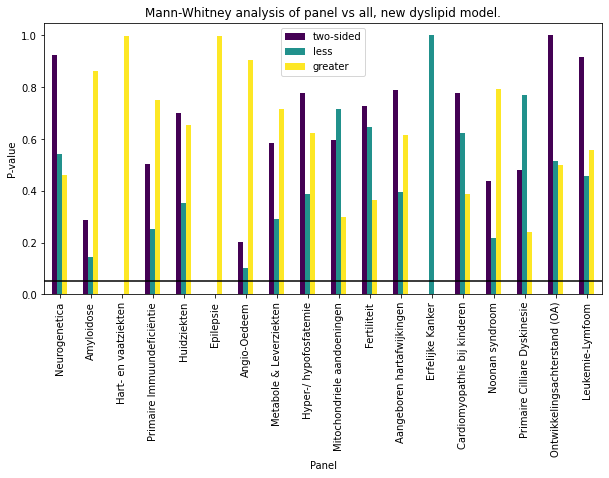

In [69]:
ax = dyslipid_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new dyslipid model.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

# AUC analysis on EK model
[Index](#Index)

# Model on best performing panel, prepartation
[Index](#Index)

In [70]:
ek = genepanels['Erfelijke Kanker']
ek

{'Borstkanker': ['ATM', 'BRCA1', 'BRCA2', 'CHEK2', 'PALB2'],
 'Borstkanker & Li Fraumeni syndroom': ['ATM',
  'BRCA1',
  'BRCA2',
  'CHEK2',
  'PALB2',
  'TP53'],
 'Darmkanker': ['EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'MUTYH',
  'PMS2',
  'POLD1',
  'POLE'],
 'Darmpoliepen': ['APC',
  'AXIN2',
  'BMPR1A',
  'ENG',
  'MSH3',
  'MUTYH',
  'NTHL1',
  'POLD1',
  'POLE',
  'PTEN',
  'RNF43',
  'SMAD4',
  'SMAD4',
  'STK11'],
 'Eierstokkanker': ['BRCA1',
  'BRCA2',
  'BRIP1',
  'EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'PMS2',
  'RAD51C',
  'RAD51D'],
 'Endocrinologie-feochromocytomen': ['FH',
  'MAX',
  'MDH2',
  'NF1',
  'RET',
  'SDHA',
  'SDHAF2',
  'SDHB',
  'SDHC',
  'SDHD',
  'TMEM127',
  'VHL'],
 'Endocrinologie-NET': ['AIP',
  'CDKN1A',
  'CDKN1B',
  'CDKN2B',
  'CDKN2C',
  'MEN1',
  'NF1',
  'PRKAR1A'],
 'Huidkanker': ['ACD',
  'ACTRT1',
  'BAP1',
  'CDK4',
  'CDKN2A',
  'ERCC2',
  'MITF',
  'POLH',
  'POT1',
  'PTCH1',
  'PTCH2',
  'SUFU',
  'TERF2IP',
  'TERT'],
 'Kinderonco-med

In [71]:
ek_genes = []
for key, values in ek.items():
    for value in values:
        if value not in ek_genes:
            ek_genes.append(value)
len(ek_genes)

87

In [72]:
ek_subset = train.loc[train['GeneName'].isin(ek_genes)]
ek_subset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
55,2,False,A,CodingTranscript,False,False,CCDS1836.1,741.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.839,-0.283,False,1.0
56,2,False,TA,CodingTranscript,False,False,CCDS1836.1,1944.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,0.001,0.466,False,1.0
57,2,False,CC,CodingTranscript,False,False,CCDS1836.1,3259.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,3.249,False,1.0
58,2,False,C,CodingTranscript,False,False,CCDS1836.1,102.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,-0.743,False,1.0
59,2,False,AT,CodingTranscript,False,False,CCDS1836.1,395.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,5.138,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334504,5,False,T,CodingTranscript,False,False,CCDS4107.1,3925.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,3.528,False,0.8
334505,5,False,GACAAAGA,CodingTranscript,False,False,CCDS4107.1,4160.0,False,"frameshift,stop_gained",...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.909,False,0.8
334533,17,False,A,CodingTranscript,False,False,CCDS45646.1,271.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.639,False,0.8
334534,17,False,A,CodingTranscript,False,False,CCDS45646.1,184.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.266,False,0.8


In [73]:
ek_subset['label'].value_counts()

Benign        16869
Pathogenic     9907
Name: label, dtype: int64

# AUC analysis new model on UMCG genepanels
[Index](#Index)

In [74]:
auc_analysis

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
0,0,LDLR,0.983725,0.992126,0.991259,0.008741,0.992995,336,1144,1480,1325,155
1,1,BRCA2,0.992003,0.995261,0.997110,0.002890,0.993418,1221,2422,3643,2973,670
2,2,BRCA1,0.986892,0.992528,0.993808,0.006192,0.991251,849,1938,2787,2226,561
3,3,MSH2,0.989096,0.990902,0.988449,0.011551,0.993367,390,606,996,850,146
4,4,USH2A,0.977106,0.970238,0.970238,0.029762,0.970238,312,168,480,459,21
...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2349,NLRP1,0.500000,0.000000,0.000000,1.000000,0.000000,14,1,15,15,0
2350,2350,APOA1,1.000000,1.000000,1.000000,0.000000,1.000000,9,1,10,9,1
2351,2351,IL2RG,0.500000,0.000000,0.000000,1.000000,0.000000,6,1,7,6,1
2352,2352,SGSM3,1.000000,1.000000,1.000000,0.000000,1.000000,3,1,4,3,1


In [75]:
genepanel_auc = genepanel_analysis(genepanels, auc_analysis)
genepanel_auc.sort_values(by='compared_to', inplace=True)

In [76]:
previous_model_auc = pd.read_csv('./not_saving_directory/previousmodelauc.csv')
previous_model_auc.sort_values(by='compared_to', inplace=True)

Text(0.5, 0, 'Panel')

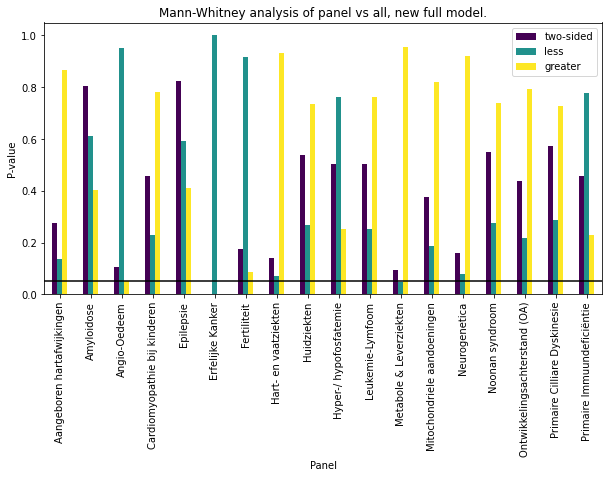

In [77]:
ax = genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new full model.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

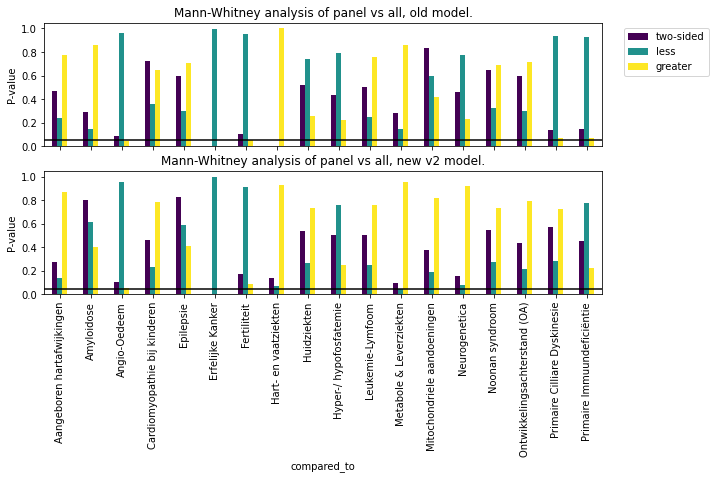

In [78]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
previous_model_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, old model.', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new v2 model.', ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_ylabel('P-value')
axes[1].hlines(y=0.05,xmin=-10,xmax=100)

# Barplot of type of variants for each panel
[Index](#Index)

In [79]:
variants = pd.read_csv('/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/datafiles/train.txt.gz', compression='gzip', sep='\t', low_memory=False)
variants

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


Text(0.5, 0, 'Consequence')

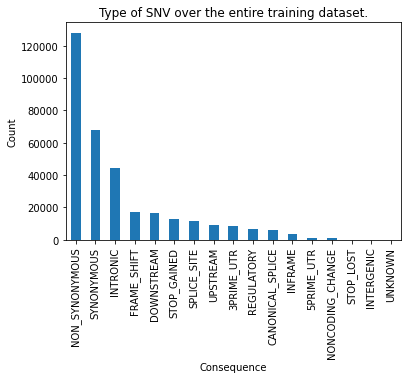

In [80]:
ax = variants['Consequence'].value_counts().plot(kind='bar')
ax.set_title('Type of SNV over the entire training dataset.')
ax.set_ylabel('Count')
ax.set_xlabel('Consequence')

In [81]:
# Reduce the information to just panels.

panels = {}
for panel in genepanels.keys():
    panels[panel] = []
    disease_panel = genepanels[panel]
    if isinstance(disease_panel, dict):
        for disease, genes in disease_panel.items():
            for gene in genes:
                if gene not in panels[panel]:
                    panels[panel].append(gene)

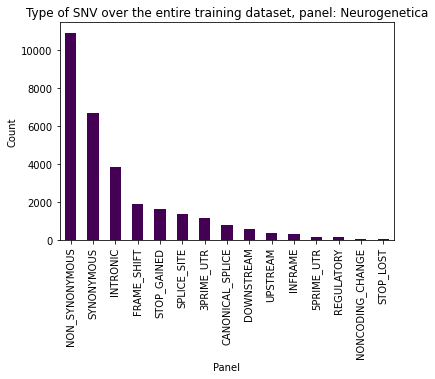

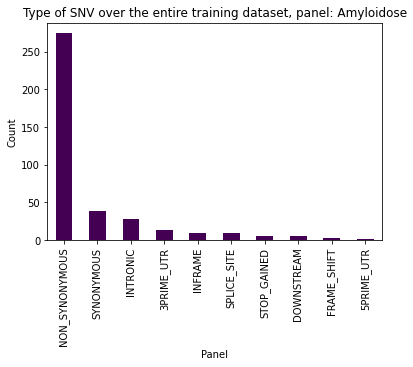

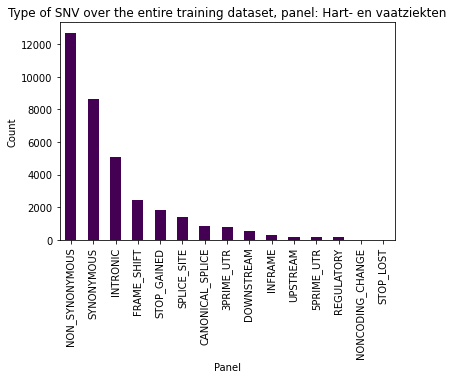

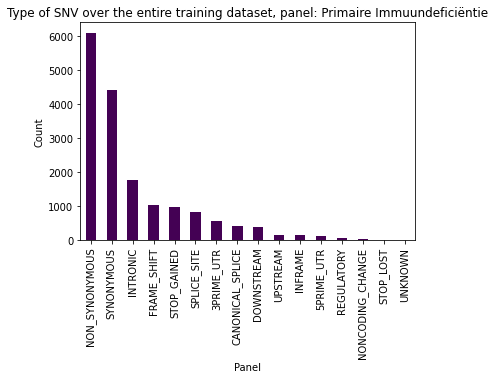

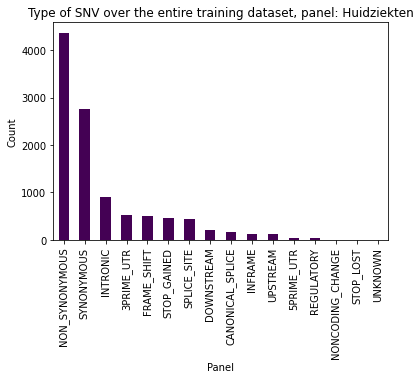

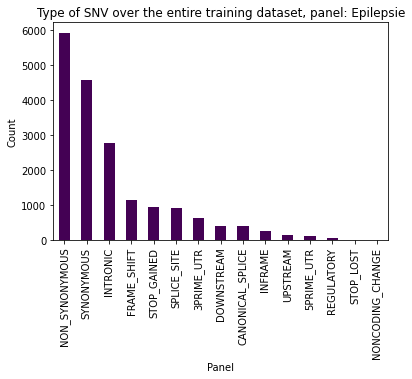

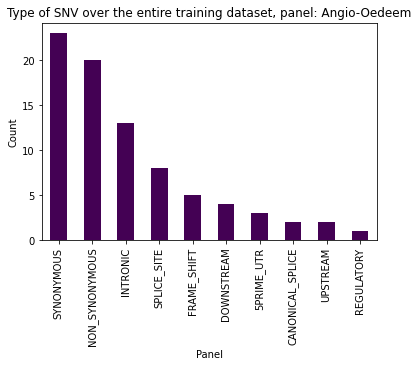

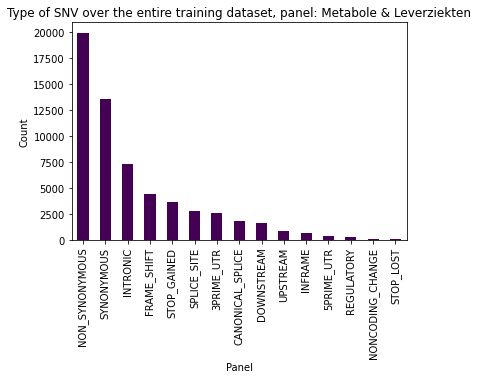

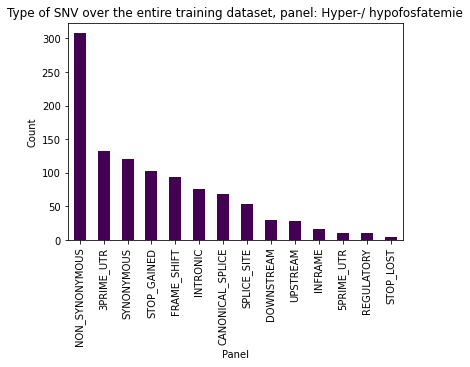

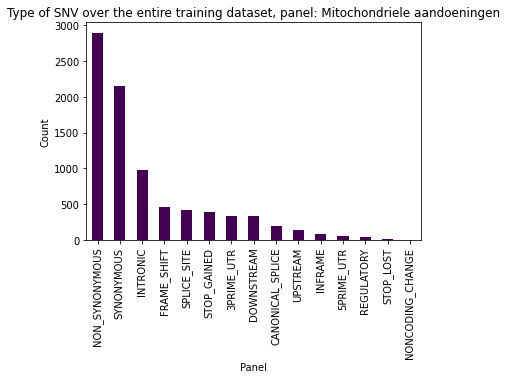

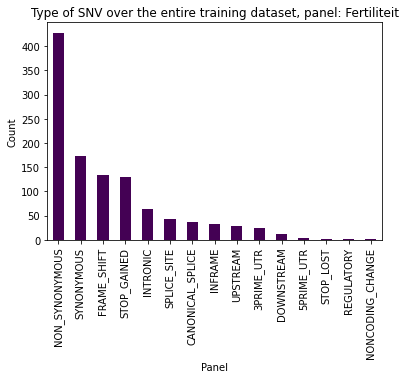

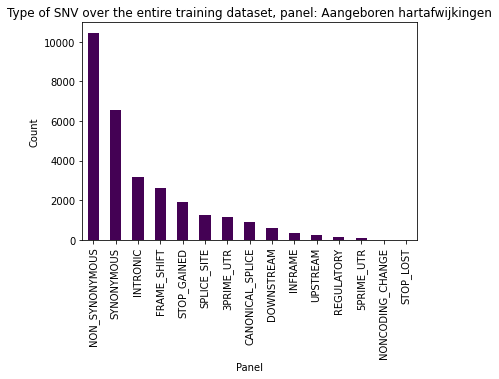

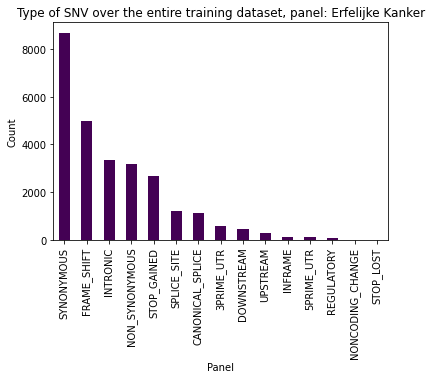

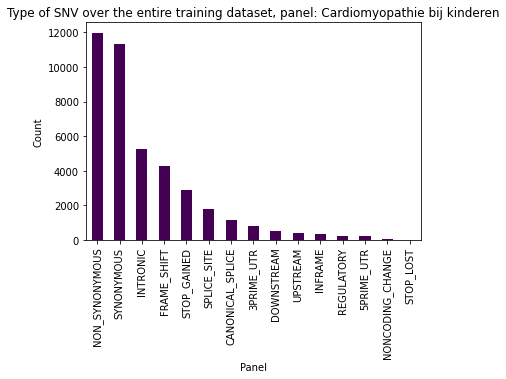

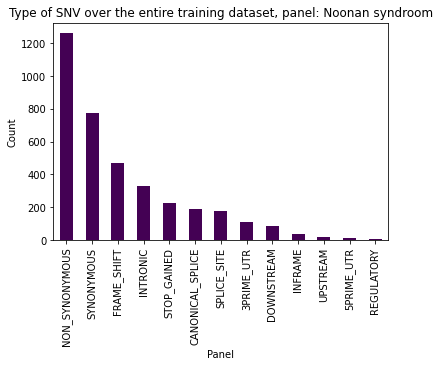

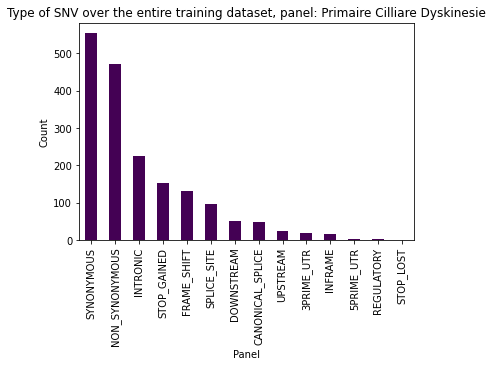

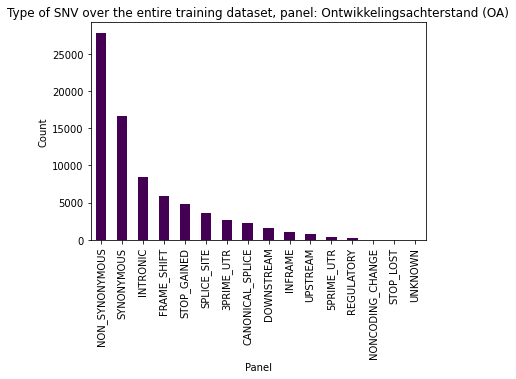

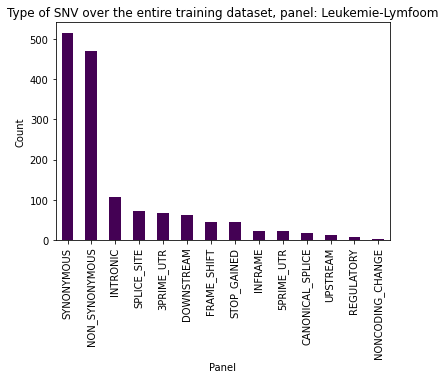

In [82]:
for panel, genes in panels.items():
    title = f'Type of SNV over the entire training dataset, panel: {panel}'
    subset = variants[variants['GeneName'].isin(genes)]
    data = subset['Consequence'].value_counts()
    ax = data.plot.bar(x='index', y='Consequence',
                      colormap='viridis',
                      title=title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Panel')
    fig = plt.Figure()
    fig.axes.append(ax)
    plt.show()